In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime
from scipy import stats, integrate
from scipy.stats import boxcox
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
file = './flamingo.xlsx'

In [3]:
df = pd.read_excel(file, sheetname = 'Sheet1')
#df

In [4]:
df.columns = ['date', 'day', 'store', 'total_sales', 'total_discount', 'real_sales', 'amount', 'tax', 'total_receipt', 'unit_price_by_receipt', 'customers', 'unit_price_by_customer', 'man', 'woman', 'volunteer', 'overcharge', 'total_payments', 'cash', 'cash_receipt', 'credit_card', 'credit', 'gift_card', 'meal_ticket', 'member_point','alliance_card', 'office_member_card', 'mobile_coupon', 'cashbee', 'store_order', 'order_ratio_by_store', 'pickup_order', 'order_ratio_by_pickup', 'delivery_order', 'order_ratio_by_delivery', 'normal_discount', 'service_discount', 'alliance_discount', 'coupon_discount', 'member_discount', 'meal_ticket_discount', 'delivery_discount', 'after_refund', 'instant_refund', 'refund_fee']
#df.head(5)

In [5]:
df_clean = df[4:186].copy()
df_clean.head(5)

,date,day,store,total_sales,total_discount,real_sales,amount,tax,total_receipt,unit_price_by_receipt,...,normal_discount,service_discount,alliance_discount,coupon_discount,member_discount,meal_ticket_discount,delivery_discount,after_refund,instant_refund,refund_fee
4,소계 : 2017-12-31,일,1개,2549100,15500,2533600,2303828,229772,318,7967,...,0,15500,0,0,0,0,0,0,0,0
5,소계 : 2017-12-30,토,1개,2261300,31200,2230100,2027840,202260,279,7993,...,0,31200,0,0,0,0,0,0,0,0
6,소계 : 2017-12-29,금,1개,2102200,15800,2086400,1897154,189246,296,7049,...,0,15800,0,0,0,0,0,0,0,0
7,소계 : 2017-12-28,목,1개,1966200,15100,1951100,1774098,177002,270,7226,...,0,15100,0,0,0,0,0,0,0,0
8,소계 : 2017-12-27,수,1개,1870100,0,1870100,1700531,169569,267,7004,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_clean['date'] = df_clean['date'].map(lambda x: x.lstrip('소계 : ').rstrip(''))
df_sort_clean = df_clean.sort_values('date')
df_sort_clean.head(5)
df_reclean = df_sort_clean.drop(df_sort_clean.columns[df_sort_clean.apply(lambda col: col.sum() == 0)], axis = 1)
df_reclean['date'] = pd.to_datetime(df_reclean['date'], format='%Y-%m-%d')
df_reclean.index = df_reclean['date']
df_reclean.head(5)

,date,day,store,total_sales,total_discount,real_sales,amount,tax,total_receipt,unit_price_by_receipt,...,total_payments,cash,cash_receipt,credit_card,store_order,order_ratio_by_store,pickup_order,order_ratio_by_pickup,normal_discount,service_discount
date,,,,,,,,,,,,,,,,,,,,,
2017-07-01,2017-07-01,토,1개,2382300,0,2382300,2166231,216069,313,7611,...,2382300,506900,17700,1857700,1908700,80.12,473600,19.88,0,0
2017-07-02,2017-07-02,일,1개,1986500,0,1986500,1806305,180195,275,7224,...,1986500,522500,35800,1428200,1645600,82.84,340900,17.16,0,0
2017-07-03,2017-07-03,월,1개,1798900,0,1798900,1635700,163200,247,7283,...,1798900,579500,0,1219400,1544700,85.87,254200,14.13,0,0
2017-07-04,2017-07-04,화,1개,2062100,0,2062100,1875061,187039,303,6806,...,2062100,454400,8500,1599200,1701200,82.5,360900,17.5,0,0
2017-07-05,2017-07-05,수,1개,2109100,0,2109100,1917772,191328,292,7223,...,2109100,514000,18800,1576300,1852100,87.81,257000,12.19,0,0


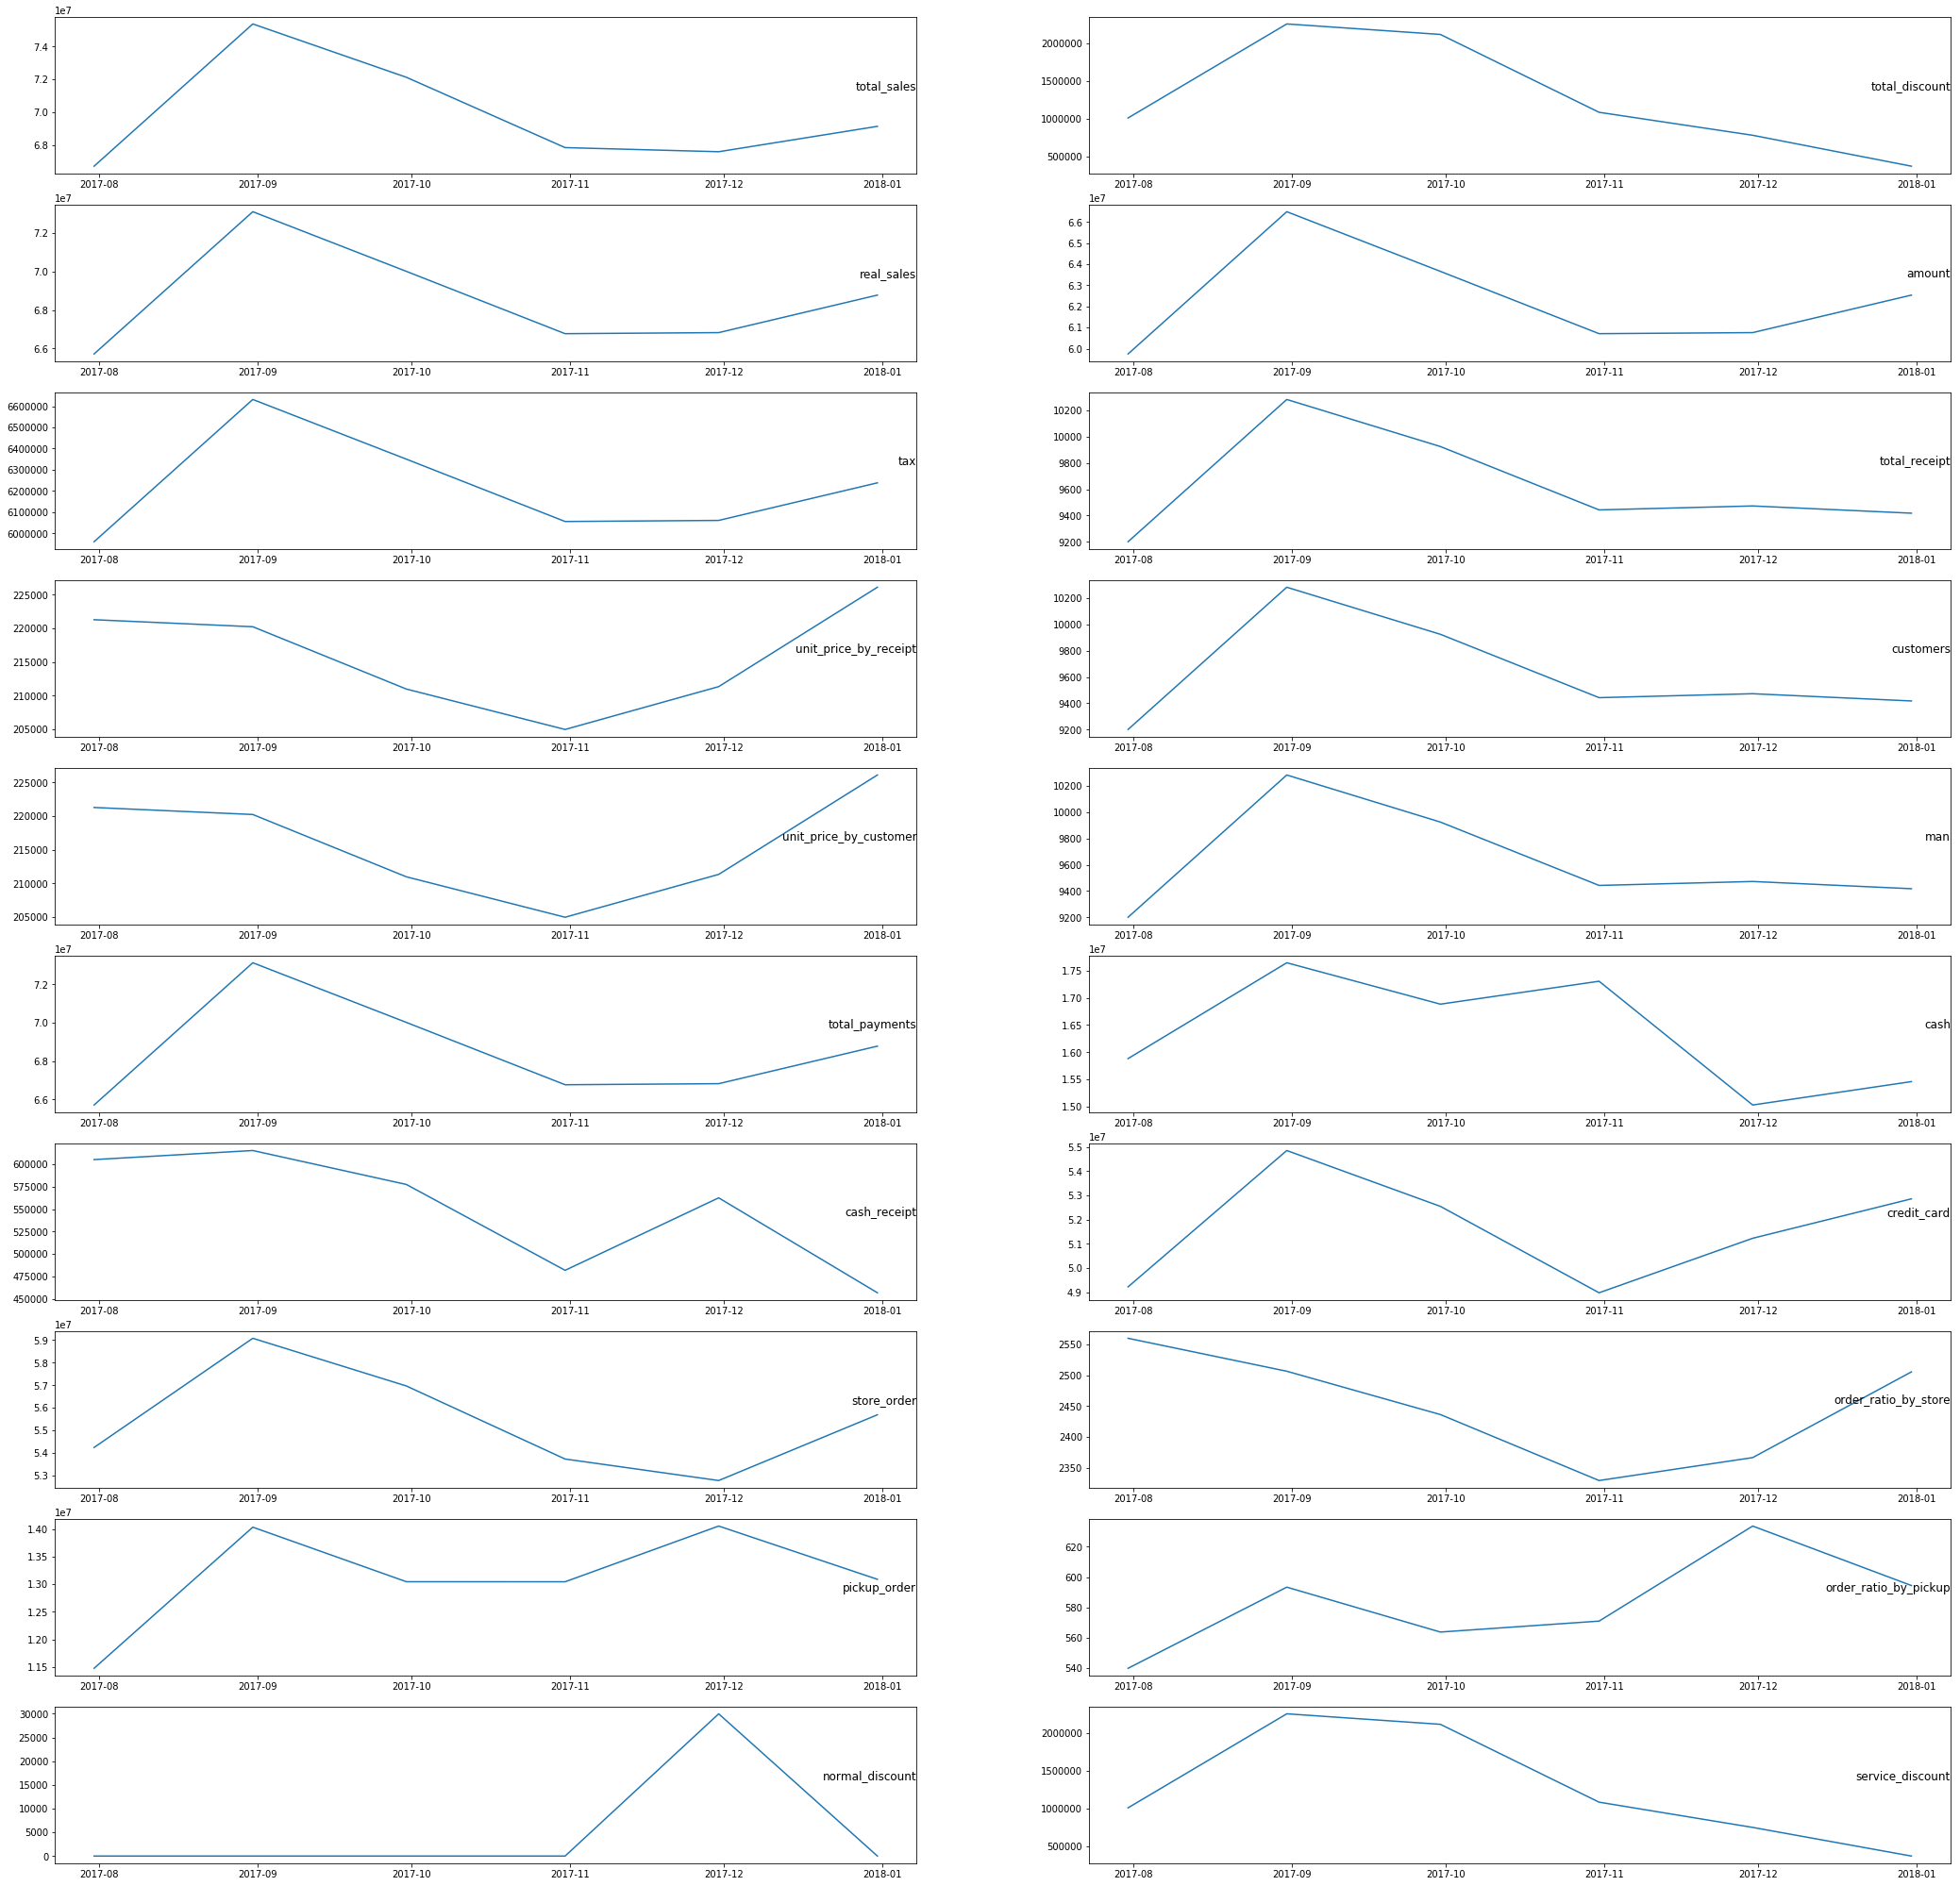

In [7]:
# load the dataset
dataset = df_reclean.drop(['day', 'store'], axis=1)
dataset_bymonth = dataset.groupby(pd.Grouper(freq='M')).sum()
dataset_bymonth.head()
# specify columns to plot
groups = list(dataset.columns[1:])
i = 1
# plot each column
plt.figure(figsize=(36, 36))
for group in groups:
    plt.subplot(len(groups)/2, 2, i)
    plt.plot(dataset_bymonth.index, dataset_bymonth[group])
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()

In [8]:
#sns.pairplot(dataset)
#plt.show()
# total_discount, unit_price_by_receipt, unit_price_by_customer, cash, cash_receipt

In [9]:
date = dataset['date']
total_sales = dataset['total_sales']
dataset.to_csv('./flamingoeats.csv', index=0)
series = Series.from_csv('./flamingoeats.csv', header=0, index_col=0)
print(series)
print(series.index)
split_point = len(series.index) - 31
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

date
2017-07-01    2382300
2017-07-02    1986500
2017-07-03    1798900
2017-07-04    2062100
2017-07-05    2109100
2017-07-06    2028300
2017-07-07    1967000
2017-07-08    2395200
2017-07-09    2139300
2017-07-10    2044500
2017-07-11    2301400
2017-07-12    1606800
2017-07-13    1907400
2017-07-14    2101600
2017-07-15    2079900
2017-07-16    2473900
2017-07-17    2196000
2017-07-18    2067500
2017-07-19    2230100
2017-07-20    2089400
2017-07-21    2225900
2017-07-22    2315000
2017-07-23    2224300
2017-07-24    2024200
2017-07-25    2388800
2017-07-26    2181400
2017-07-27    2144700
2017-07-28    2001300
2017-07-29    2600000
2017-07-30    2481600
               ...   
2017-12-02    2345700
2017-12-03    2301200
2017-12-04    1719500
2017-12-05    2005800
2017-12-06    2209500
2017-12-07    2118400
2017-12-08    2133400
2017-12-09    2800900
2017-12-10    2319300
2017-12-11    1891100
2017-12-12    2340000
2017-12-13    2333300
2017-12-14    2111200
2017-12-15    2216800
2017-

In [10]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=2481500.000, Expected=2886300
>Predicted=2886300.000, Expected=2521500
>Predicted=2521500.000, Expected=2492600
>Predicted=2492600.000, Expected=1854000
>Predicted=1854000.000, Expected=2531700
>Predicted=2531700.000, Expected=2482700
>Predicted=2482700.000, Expected=2676700
>Predicted=2676700.000, Expected=2624700
>Predicted=2624700.000, Expected=1971300
>Predicted=1971300.000, Expected=2242000
>Predicted=2242000.000, Expected=2263100
>Predicted=2263100.000, Expected=2333900
>Predicted=2333900.000, Expected=2563100
>Predicted=2563100.000, Expected=2725600
>Predicted=2725600.000, Expected=1895700
>Predicted=1895700.000, Expected=2256600
>Predicted=2256600.000, Expected=1951200
>Predicted=1951200.000, Expected=2007800
>Predicted=2007800.000, Expected=2140500
>Predicted=2140500.000, Expected=2830500
>Predicted=2830500.000, Expected=2943800
>Predicted=2943800.000, Expected=2125600
>Predicted=2125600.000, Expected=2114400
>Predicted=2114400.000, Expected=2193200
>Predicted=21932

In [11]:
print(series.describe())

count    1.820000e+02
mean     2.301090e+06
std      2.871816e+05
min      1.606800e+06
25%      2.123050e+06
50%      2.228000e+06
75%      2.479600e+06
max      3.010000e+06
Name: total_sales, dtype: float64


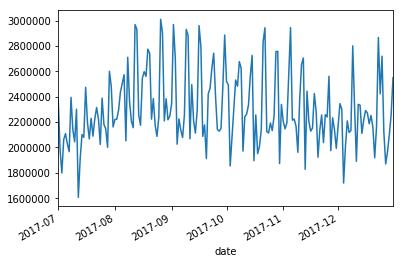

In [12]:
series.plot()
plt.show()

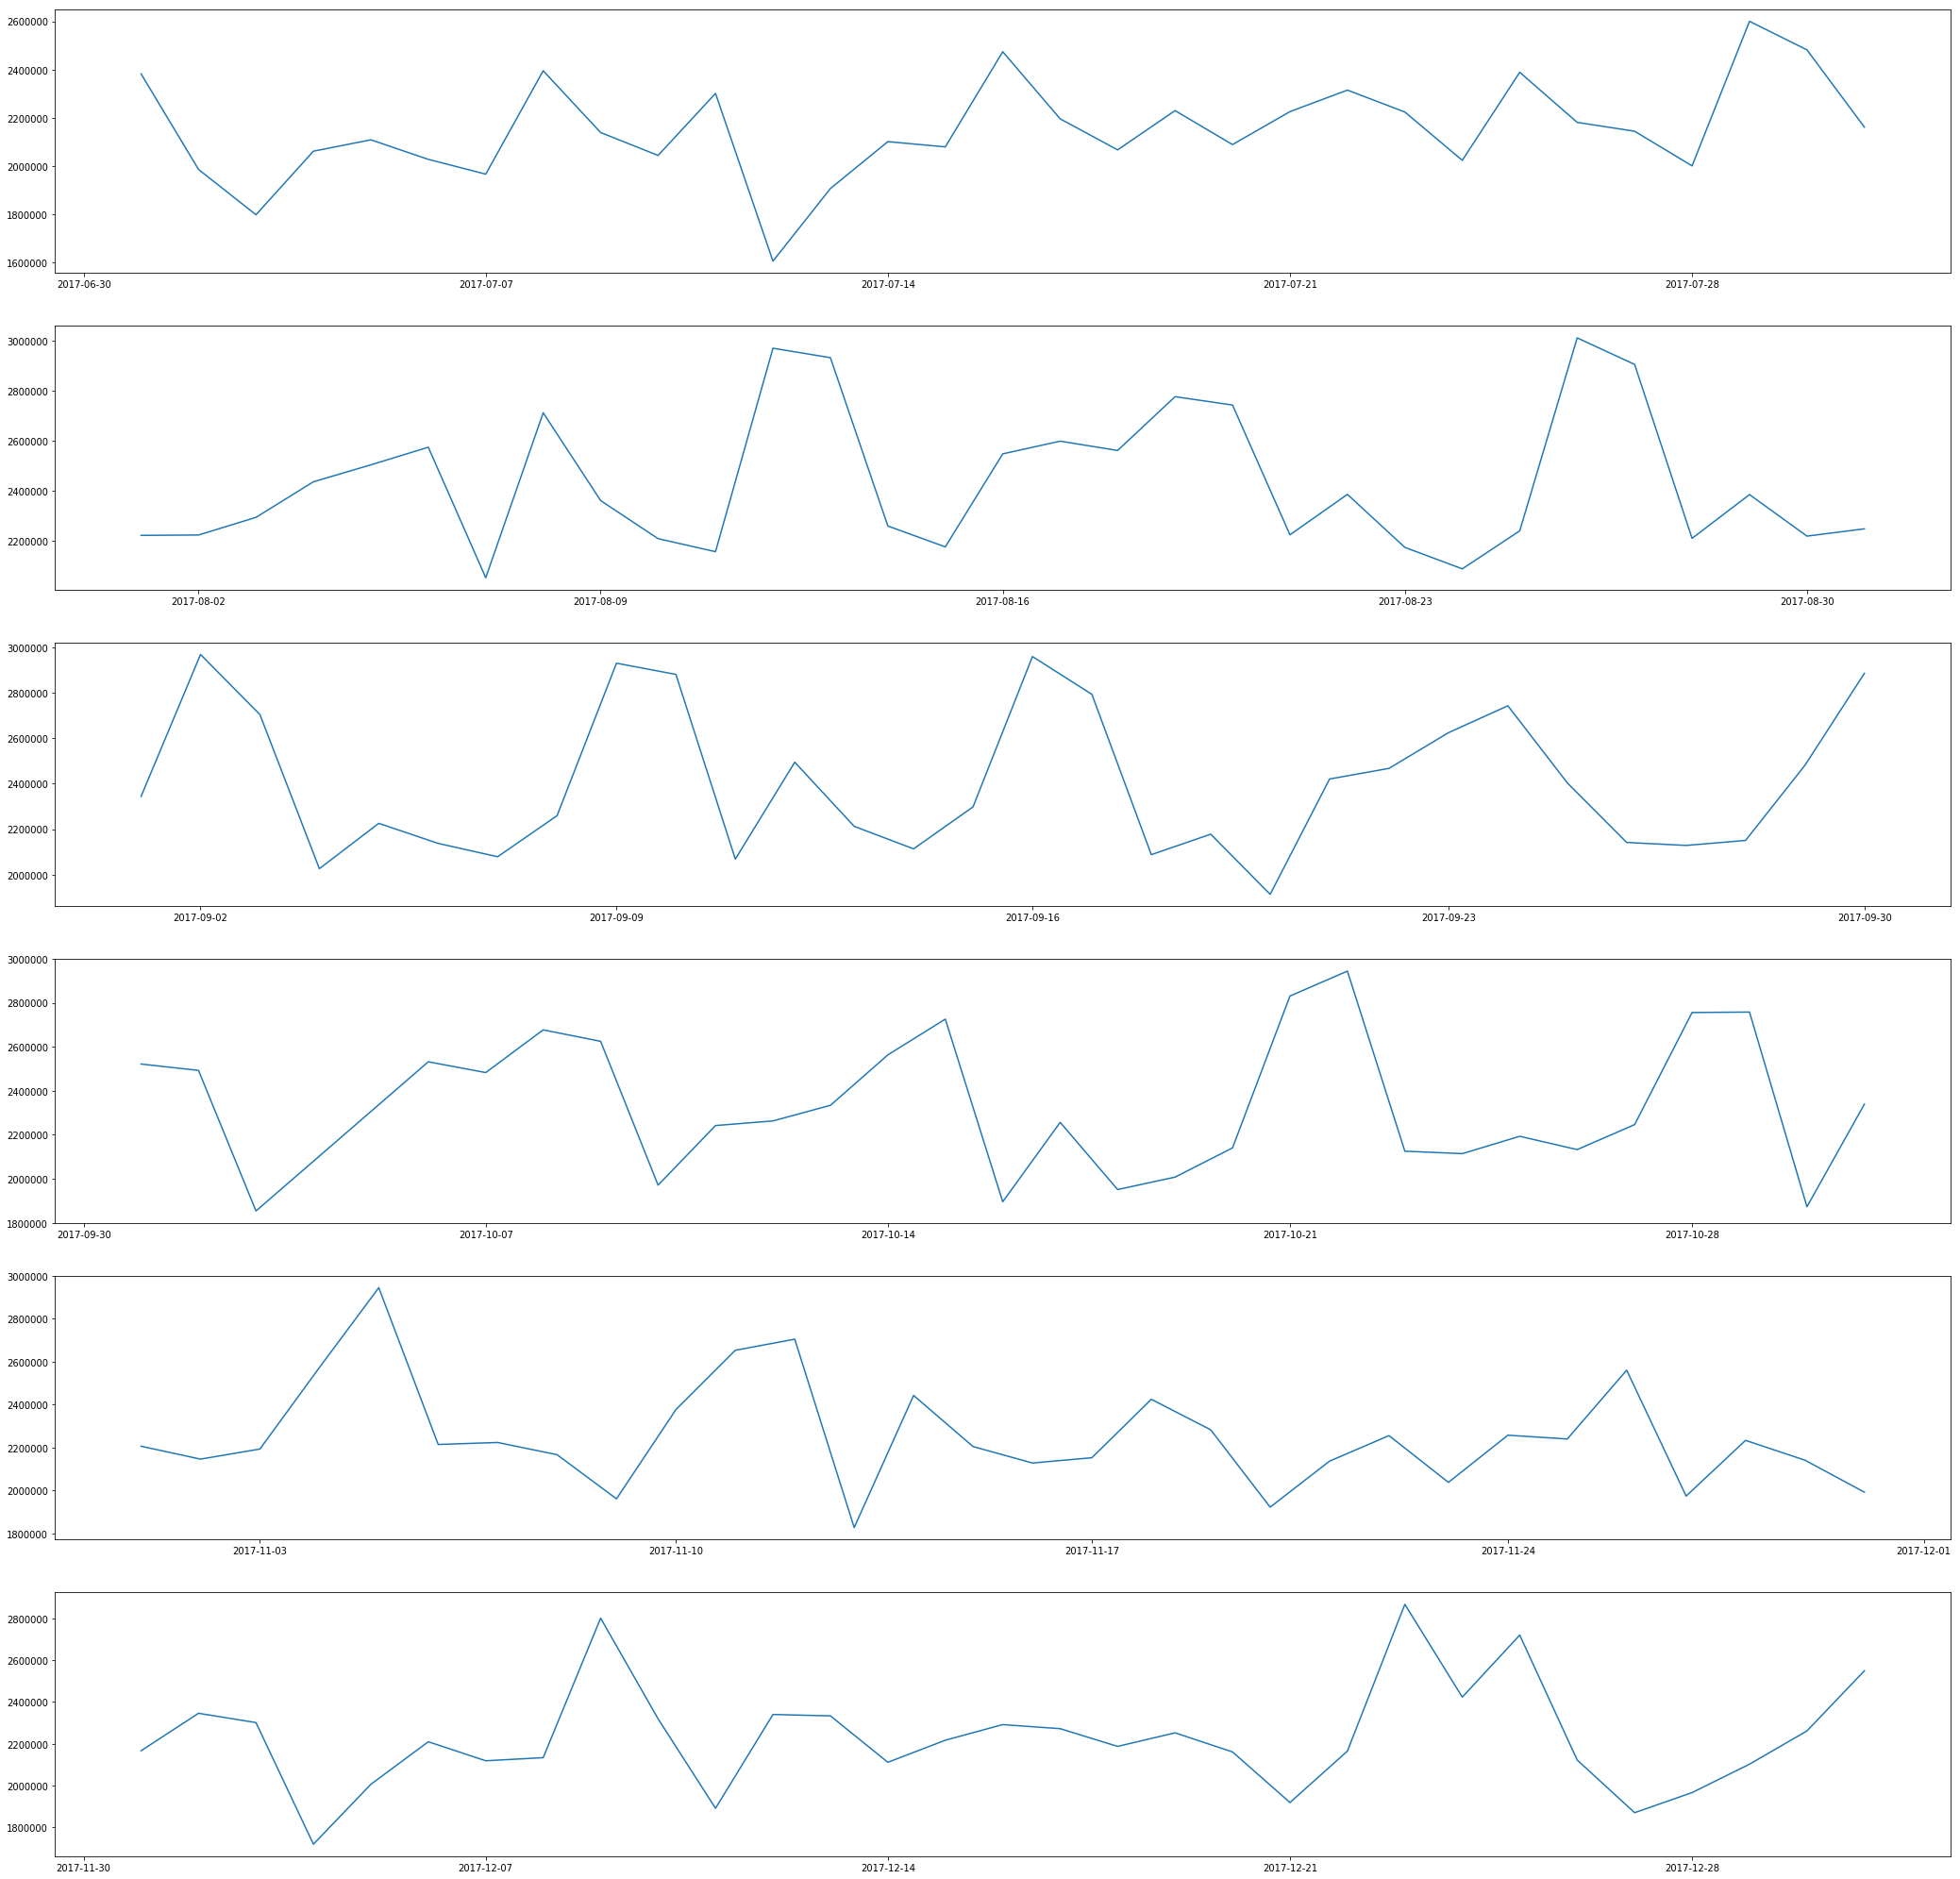

In [13]:
groups = series['2017-07':'2017-12'].groupby(TimeGrouper('M'))
months = DataFrame()
plt.figure(figsize=(36, 36))
i = 1
n_groups = len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    plt.plot(group)
plt.show()

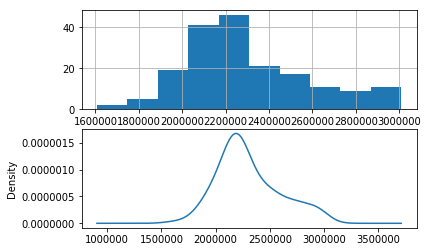

In [14]:
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

ADF Statistic: -2.512478
p-value: 0.112468
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


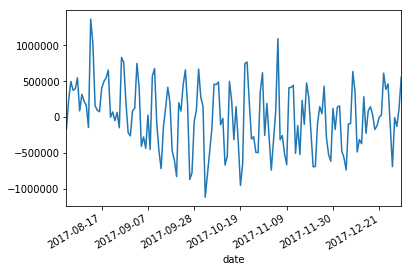

In [15]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

X = series.values
X = X.astype('float32')
# difference data
days_in_month = 31
stationary = difference(X, days_in_month)
stationary.index = series.index[days_in_month:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
plt.show()

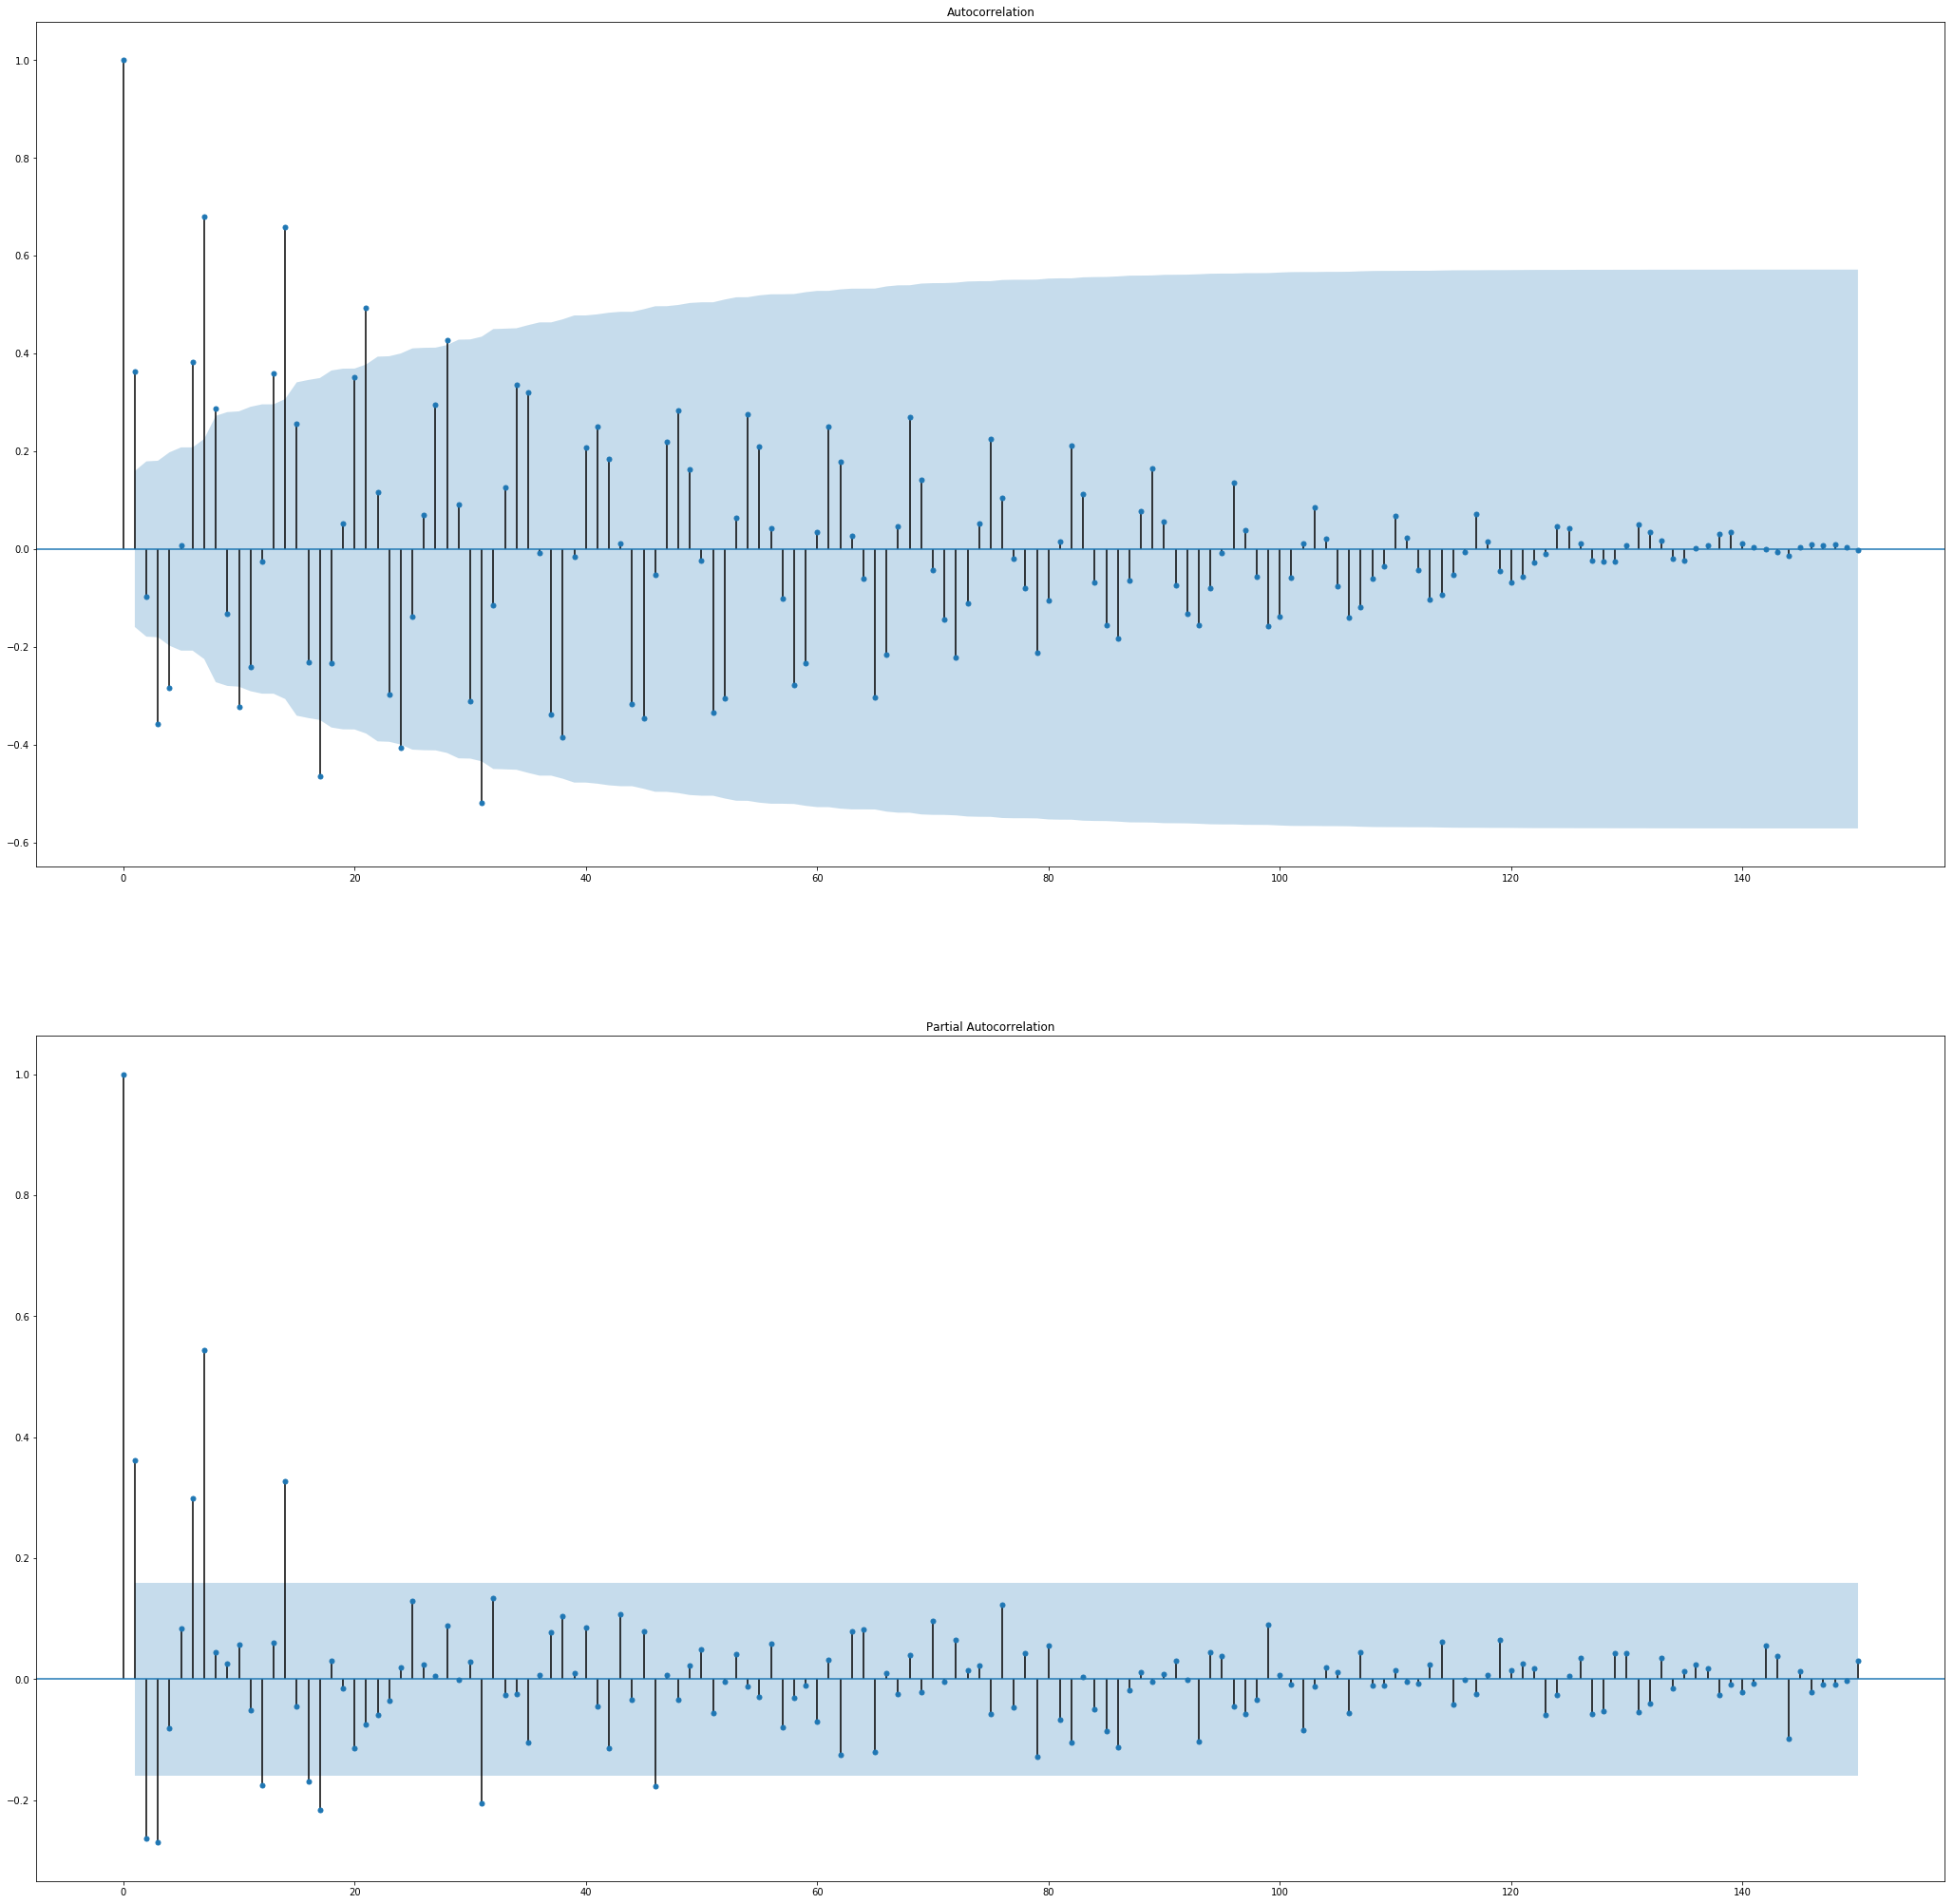

In [16]:
series = Series.from_csv('stationary.csv')
plt.figure(figsize=(36, 36))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [17]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        days_in_month = 31
        diff = difference(history, days_in_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, days_in_month)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=448608.413
ARIMA(0, 0, 2) RMSE=452131.886
ARIMA(0, 0, 3) RMSE=434334.625
ARIMA(0, 0, 4) RMSE=436791.129
ARIMA(0, 0, 5) RMSE=416468.731
ARIMA(0, 0, 6) RMSE=426585.372
ARIMA(0, 1, 1) RMSE=520366.947
ARIMA(0, 1, 2) RMSE=459811.376
ARIMA(0, 1, 3) RMSE=465210.458
ARIMA(0, 2, 1) RMSE=570102.384
ARIMA(1, 0, 0) RMSE=460661.403
ARIMA(1, 0, 1) RMSE=452608.235
ARIMA(1, 1, 0) RMSE=566725.743
ARIMA(1, 2, 0) RMSE=749382.956
ARIMA(2, 0, 0) RMSE=437355.075
ARIMA(2, 0, 1) RMSE=425700.490
ARIMA(2, 1, 0) RMSE=560904.069
ARIMA(2, 2, 0) RMSE=735007.672
ARIMA(3, 0, 0) RMSE=418124.856
ARIMA(3, 1, 0) RMSE=524696.440
ARIMA(3, 2, 0) RMSE=706554.563
ARIMA(4, 0, 0) RMSE=421082.235
ARIMA(4, 0, 1) RMSE=404598.036
ARIMA(4, 1, 0) RMSE=490353.837
ARIMA(4, 1, 1) RMSE=384181.661
ARIMA(4, 2, 0) RMSE=684574.454
ARIMA(5, 0, 0) RMSE=424313.304
ARIMA(5, 0, 1) RMSE=383045.816
ARIMA(5, 1, 0) RMSE=429927.345
ARIMA(5, 1, 1) RMSE=353006.919
ARIMA(5, 2, 0) RMSE=645983.699
ARIMA(6, 0, 0) RMSE=404938.966
ARIMA(6,

                   0
count      76.000000
mean    -2714.814010
std    326446.847186
min   -648229.509178
25%   -235486.295979
50%    -39473.496752
75%    224226.790647
max    698333.613551


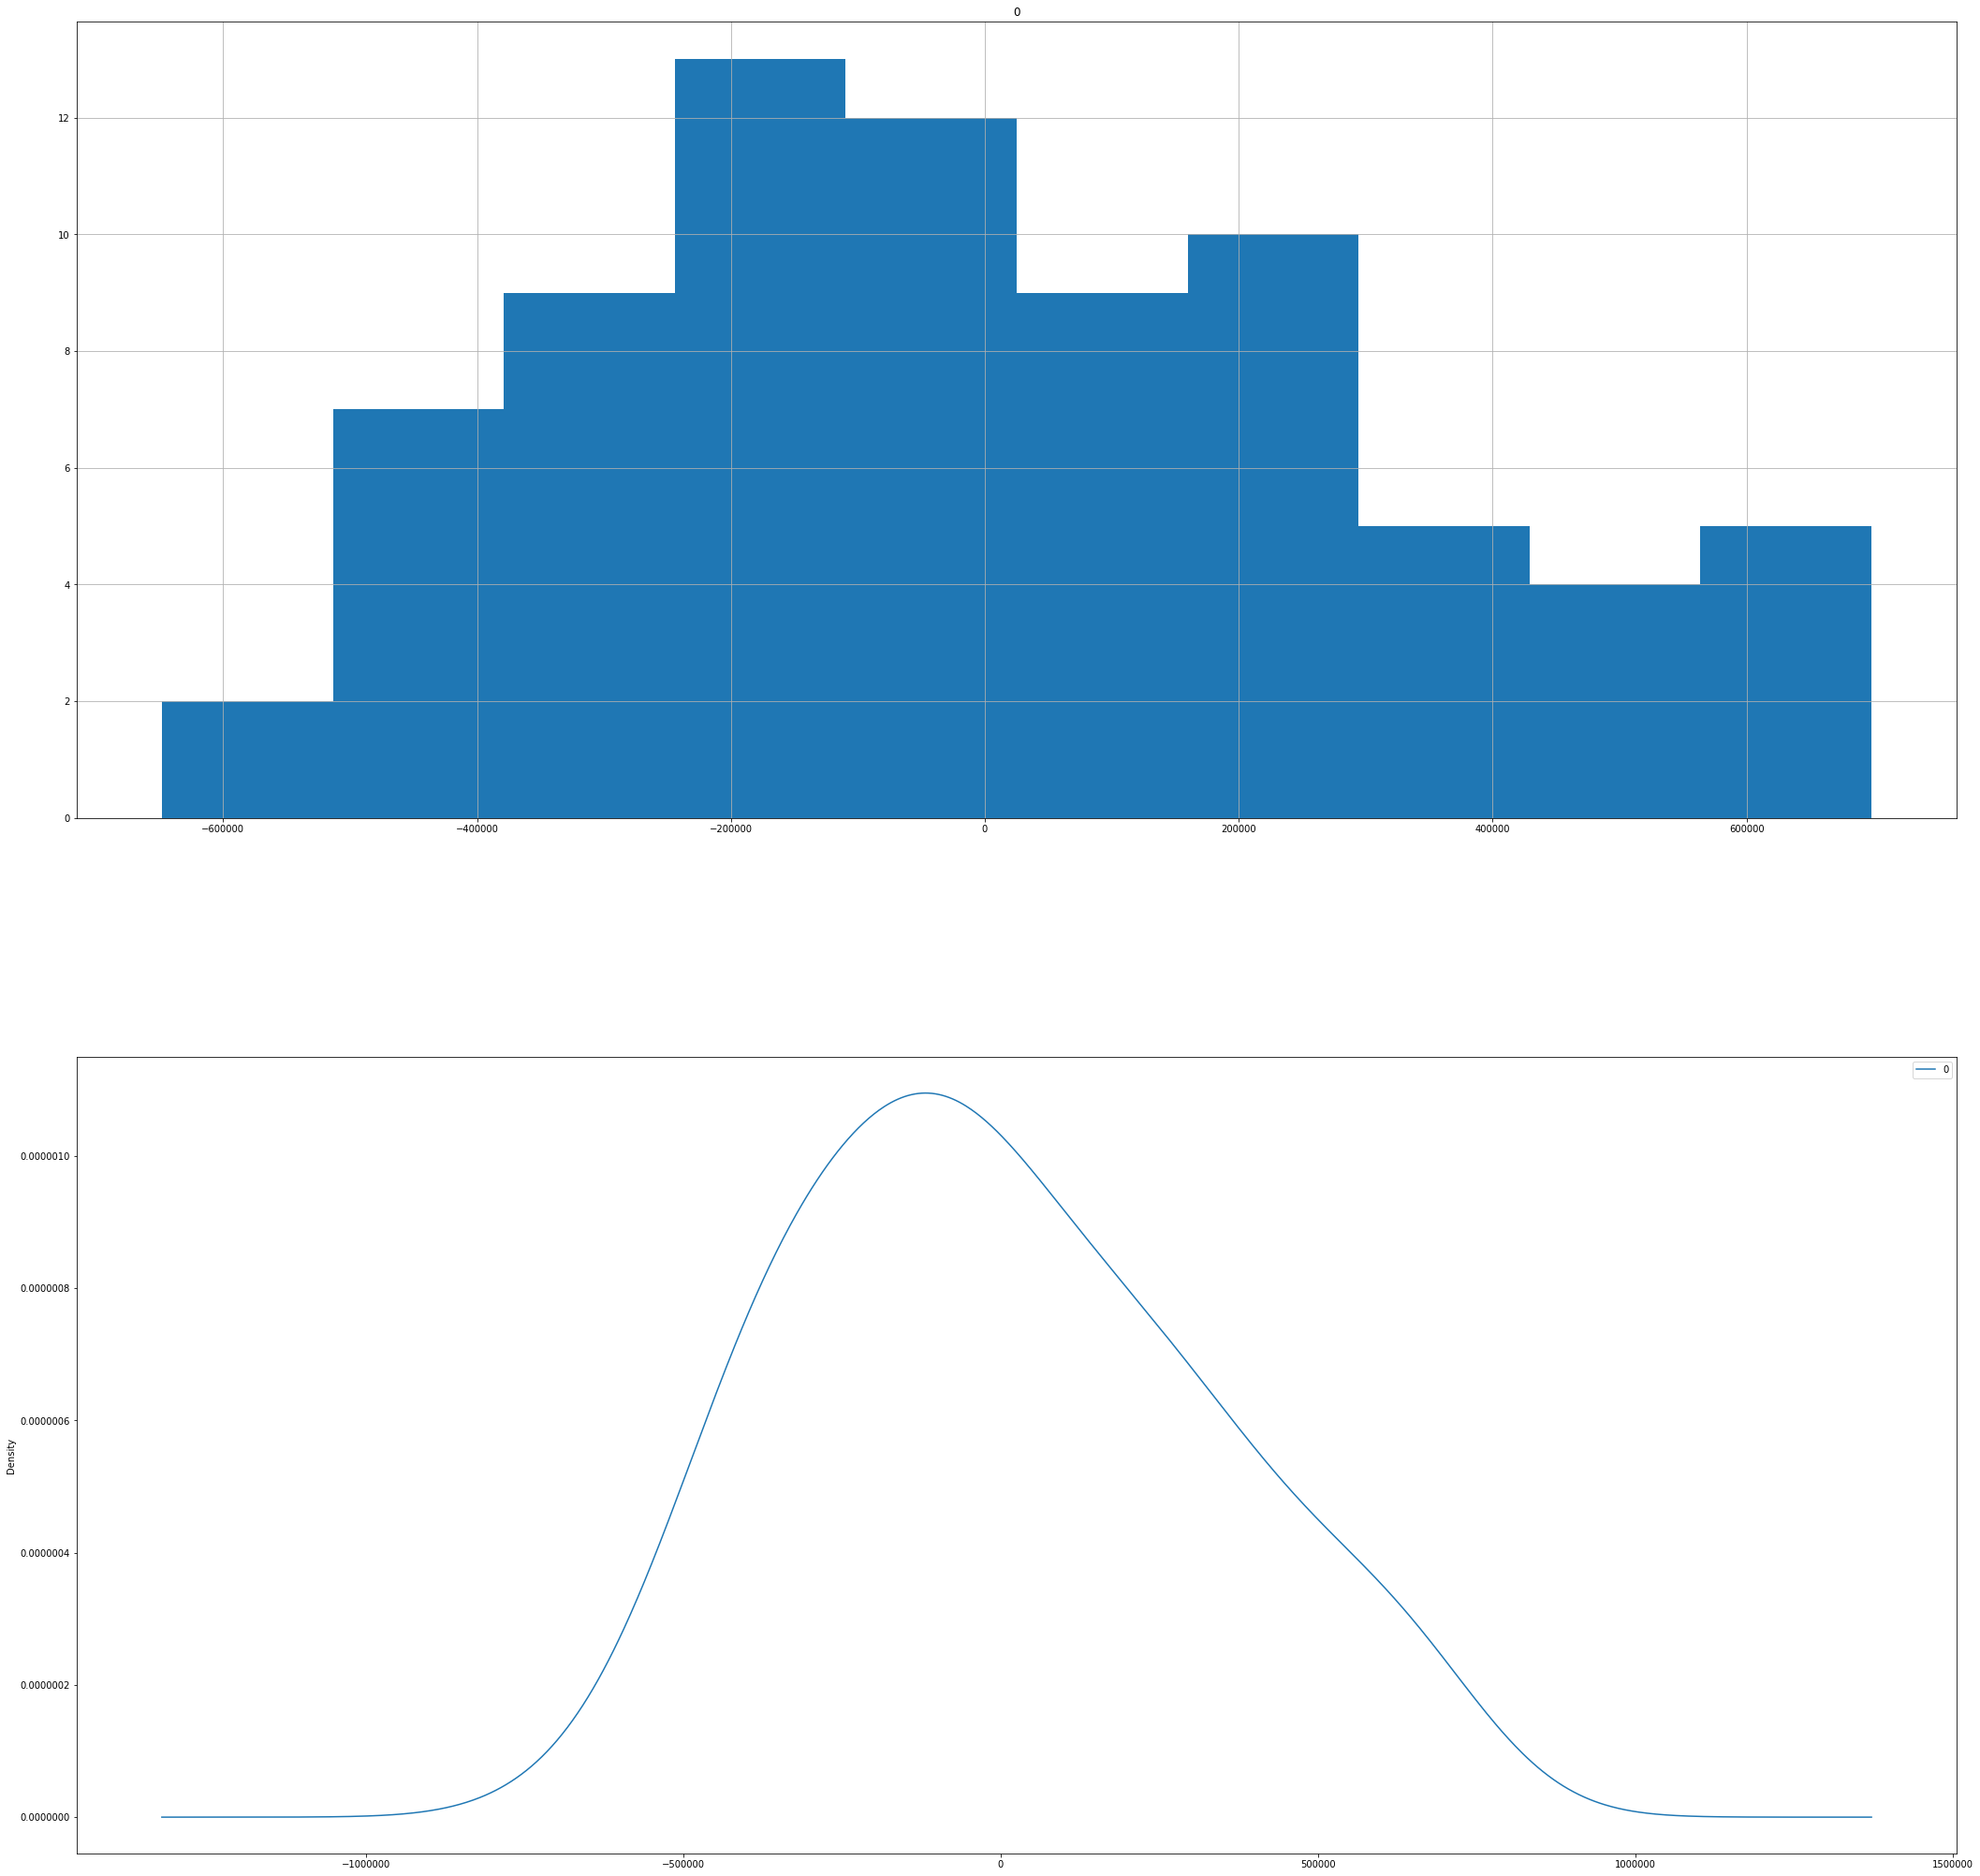

In [18]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    days_in_month = 31
    diff = difference(history, days_in_month)
    # predict
    model = ARIMA(diff, order=(6,1,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_in_month)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure(figsize=(36, 36))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

RMSE: 326839.268
                   0
count      76.000000
mean    40725.354037
std    326446.868052
min   -604789.369178
25%   -192046.155979
50%      3966.643248
75%    267667.168331
max    741773.753551


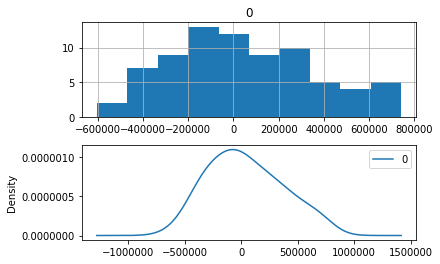

In [19]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -4.344014e+04
for i in range(len(test)):
    # difference data
    days_in_month = 31
    diff = difference(history, days_in_month)
    # predict
    model = ARIMA(diff, order=(6,1,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, days_in_month)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

                   0
count      76.000000
mean    -2714.797479
std    326446.853262
min   -648229.509178
25%   -235486.295979
50%    -39473.458782
75%    224226.790647
max    698332.618673


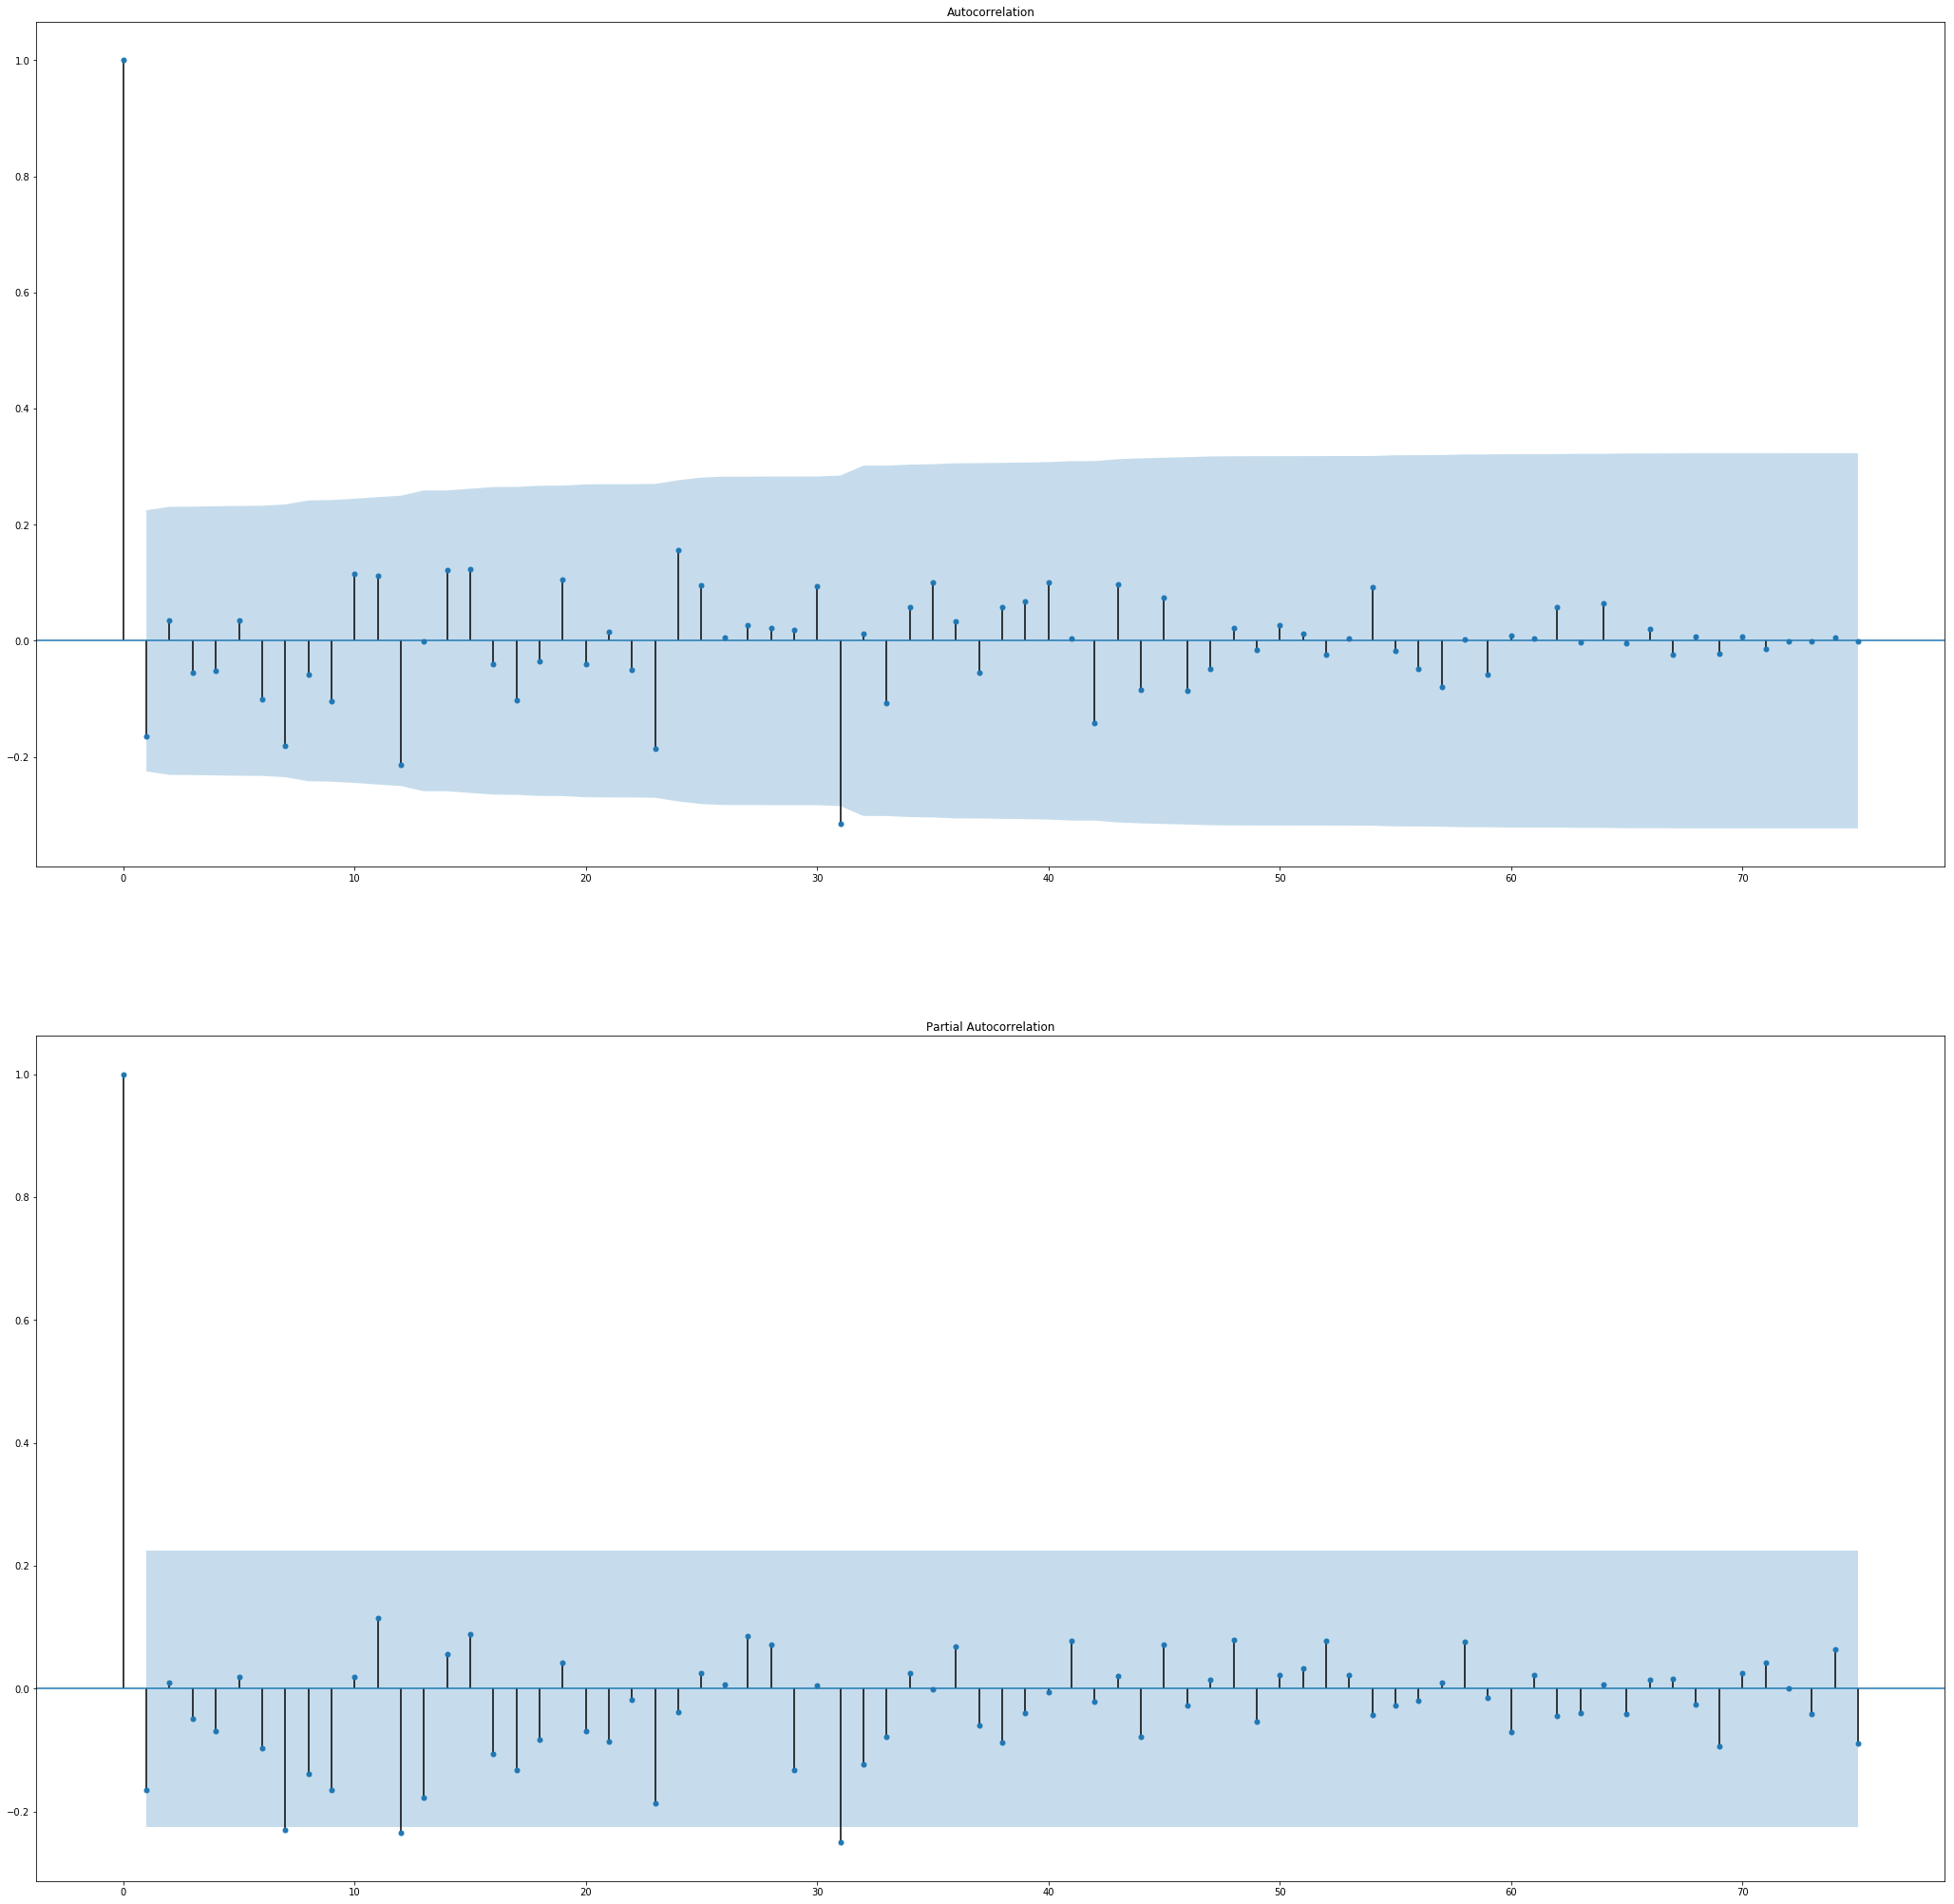

In [20]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    days_in_year = 31
    diff = difference(history, days_in_month)
    # predict
    model = ARIMA(diff, order=(6,1,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_in_month)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure(figsize=(36, 36))
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

In [21]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
days_in_month = 31
diff = difference(X, days_in_month)
# fit model
model = ARIMA(diff, order=(6,1,2))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = -4.344014e+04
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [22]:
from statsmodels.tsa.arima_model import ARIMAResults
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

series = Series.from_csv('dataset.csv')
days_in_month = 31
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, days_in_month)
print('Predicted: %.3f' % yhat)

Predicted: 2468932.646


>Predicted=2468932.646, Expected=2166400
>Predicted=2248527.160, Expected=2345700
>Predicted=2259695.798, Expected=2301200
>Predicted=1957320.513, Expected=1719500
>Predicted=2019184.458, Expected=2005800
>Predicted=2468671.255, Expected=2209500
>Predicted=2169700.744, Expected=2118400
>Predicted=2182508.707, Expected=2133400
>Predicted=2229789.077, Expected=2800900
>Predicted=1925080.237, Expected=2319300
>Predicted=1903113.067, Expected=1891100
>Predicted=1900749.312, Expected=2340000
>Predicted=2111453.093, Expected=2333300
>Predicted=1681108.100, Expected=2111200
>Predicted=2470288.295, Expected=2216800
>Predicted=2511354.818, Expected=2291500
>Predicted=2224488.440, Expected=2272000
>Predicted=1881372.810, Expected=2187300
>Predicted=2096428.656, Expected=2252100
>Predicted=1948820.868, Expected=2160800
>Predicted=1958544.631, Expected=1918700
>Predicted=2004610.911, Expected=2164700
>Predicted=2279981.854, Expected=2867000
>Predicted=2125573.947, Expected=2423000
>Predicted=21919

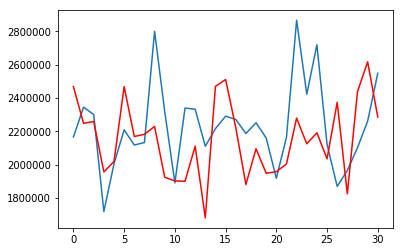

In [23]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, days_in_month)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # difference data
    days_in_month = 31
    diff = difference(history, days_in_month)
    # predict
    model = ARIMA(diff, order=(6,1,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, days_in_month)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

In [24]:
print(y.sum(), sum(predictions))

69140400.0 [66797614.47809274]
